In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
import pandas as pd
import os
LOGS = 'logs'
DATA = 'origin_data_csv'
try:
    mort_match = pd.read_csv(os.path.join(LOGS,"mort_match.csv"))
    surv_match = pd.read_csv(os.path.join(LOGS,"surv_match.csv"))
    ICUSTAY = pd.read_csv(os.path.join(DATA,"ICUSTAYS.csv"))
except FileNotFoundError as e:
    print(f"Error: {e}")
    

target_cols = ['SUBJECT_ID','ICUSTAY_ID','HOSPITAL_EXPIRE_FLAG']
patients = pd.concat([mort_match[target_cols],surv_match[target_cols]],axis = 0)
patients = patients.merge(ICUSTAY[['ICUSTAY_ID','LOS']],on='ICUSTAY_ID',how='inner').drop_duplicates()

# LOS : unit day, how long the patient stayed in the ICU
# Turn LOS unit from day in hour
# patients['LOS'] = (patients['LOS'] * 24).astype(int)
patients['HOSPITAL_EXPIRE_FLAG'] = patients['HOSPITAL_EXPIRE_FLAG'].astype(bool)
print(patients.head())
patients.to_csv(os.path.join("patients.csv"),index=False)


   SUBJECT_ID  ICUSTAY_ID  HOSPITAL_EXPIRE_FLAG      LOS
0         491      235261                  True   1.7485
1         773      213086                  True  27.6620
2        1049      264612                  True   5.9303
3        2586      258569                  True  14.6590
4        3171      204315                  True   0.7483


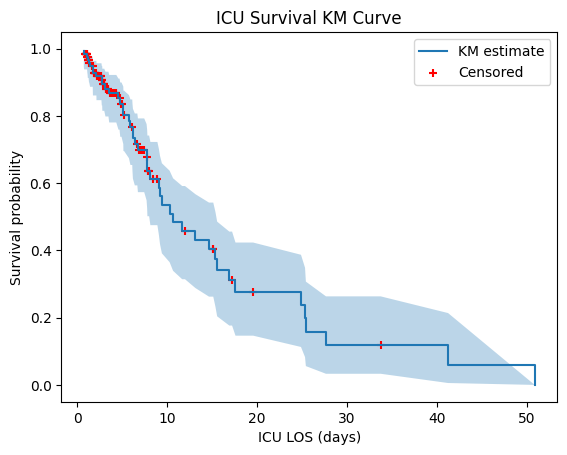

In [17]:
from sksurv.nonparametric import kaplan_meier_estimator
import matplotlib.pyplot as plt

time = patients['LOS'].to_numpy()
event = patients['HOSPITAL_EXPIRE_FLAG'].to_numpy()

times, survival_prob, conf_int = kaplan_meier_estimator(event, time, conf_type="log-log")

plt.step(times, survival_prob, where="post", label="KM estimate")
plt.fill_between(times, conf_int[0], conf_int[1], alpha=0.3)

# 標示 censored (出院存活)
censored_times = time[~event]
plt.scatter(censored_times, survival_prob[np.searchsorted(times, censored_times, side="right") - 1],
            marker="+", color="red", label="Censored")

plt.xlabel("ICU LOS (days)")
plt.ylabel("Survival probability")
plt.title("ICU Survival KM Curve")
plt.legend()
plt.show()


(<Figure size 900x600 with 2 Axes>,
 {'n_total': 126,
  'n_event': 45,
  'n_censored': 81,
  'times': array([ 0.7483,  0.7823,  0.8533,  0.9251,  0.9522,  0.9532,  0.9583,
          0.994 ,  0.9963,  1.0141,  1.0247,  1.0718,  1.0837,  1.1113,
          1.1457,  1.1516,  1.1554,  1.1573,  1.1934,  1.1973,  1.2419,
          1.253 ,  1.2778,  1.3227,  1.3289,  1.346 ,  1.4436,  1.6234,
          1.7404,  1.7485,  1.7621,  1.8314,  1.8408,  1.9598,  1.9617,
          2.0087,  2.0185,  2.1459,  2.1564,  2.212 ,  2.22  ,  2.3028,
          2.3636,  2.4314,  2.5424,  2.6812,  2.7075,  2.7438,  2.7647,
          2.7764,  2.787 ,  2.8086,  2.8768,  2.9994,  3.0185,  3.0206,
          3.1522,  3.2043,  3.2517,  3.4154,  3.4864,  3.5676,  3.7047,
          3.8067,  3.8084,  3.8731,  4.0049,  4.1202,  4.1934,  4.3522,
          4.3566,  4.5981,  4.7199,  4.795 ,  4.9147,  4.9364,  5.1343,
          5.1501,  5.2257,  5.7595,  5.9303,  6.1305,  6.1602,  6.2049,
          6.4153,  6.6948,  6.7603, 

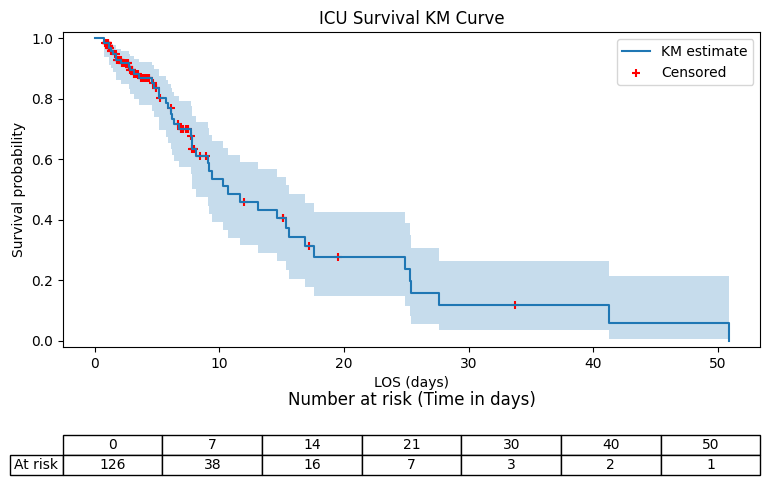

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

def compute_km(time, event, conf_type="log-log"):
    """
    計算 Kaplan-Meier。
    參數:
      time: 1D array-like (numeric) 每位病人的觀察時間
      event: 1D boolean array-like (True=event/death, False=censored)
      conf_type: "log-log" or None. 若系統有 scikit-survival，會嘗試使用它計算 CI。
    回傳:
      times: array of event times (sorted)
      surv: array of KM estimates at those times
      lower: array of lower CI (or None)
      upper: array of upper CI (or None)
    """
    time = np.asarray(time)
    event = np.asarray(event, dtype=bool)

    # 嘗試使用 scikit-survival 的 kaplan_meier_estimator（若安裝）
    try:
        from sksurv.nonparametric import kaplan_meier_estimator
        if conf_type is not None:
            times, surv, conf_int = kaplan_meier_estimator(event, time, conf_type=conf_type)
            lower, upper = conf_int
        else:
            times, surv = kaplan_meier_estimator(event, time)
            lower = upper = None
        return np.array(times), np.array(surv), (np.array(lower) if lower is not None else None), (np.array(upper) if upper is not None else None)
    except Exception:
        # fallback: 手動用 Greenwood + log-log (pointwise) 計算 CI
        unique_event_times = np.sort(np.unique(time[event]))
        times = []
        surv = []
        cum_var = 0.0
        S = 1.0
        var_list = []
        for t in unique_event_times:
            n_i = np.sum(time >= t)         # at risk just before t
            d_i = np.sum((time == t) & event)
            if n_i == 0:
                continue
            q = 1.0 - (d_i / n_i)
            S = S * q
            # Greenwood increment
            if n_i - d_i > 0:
                cum_var += d_i / (n_i * (n_i - d_i))
            times.append(t)
            surv.append(S)
            var_list.append((S**2) * cum_var)
        times = np.array(times)
        surv = np.array(surv)
        var = np.array(var_list)

        # compute log-log CI
        if conf_type == "log-log":
            alpha = 0.05
            z = 1.96
            lower = np.zeros_like(surv)
            upper = np.zeros_like(surv)
            for i, Sval in enumerate(surv):
                if Sval <= 0:
                    lower[i] = 0.0; upper[i] = 0.0; continue
                if Sval >= 1.0:
                    lower[i] = 1.0; upper[i] = 1.0; continue
                varS = var[i]
                denom = Sval * np.log(Sval)
                if denom == 0 or varS <= 0:
                    lower[i] = max(0.0, Sval)
                    upper[i] = min(1.0, Sval)
                    continue
                se_z = np.sqrt(varS) / abs(denom)
                zval = np.log(-np.log(Sval))
                z_low = zval - z * se_z
                z_up = zval + z * se_z
                S_low = np.exp(-np.exp(z_up))
                S_up = np.exp(-np.exp(z_low))
                lower[i] = max(0.0, S_low)
                upper[i] = min(1.0, S_up)
            return times, surv, lower, upper
        else:
            return times, surv, None, None


def compute_n_at_risk(time, ticks):
    """
    計算每個 ticks (時間點) 的 n-at-risk: number of subjects with time >= t
    參數:
      time: array-like of observed times
      ticks: iterable of time points to compute n-at-risk
    回傳:
      list of counts aligned with ticks
    """
    time = np.asarray(time)
    ticks = np.asarray(ticks)
    return [int(np.sum(time >= t)) for t in ticks]

def plot_km_with_natrisk(times, surv, lower=None, upper=None,
                         censor_times=None, censor_vals=None,
                         ticks=None, n_at_risk=None,
                         xlabel="Time", ylabel="Survival probability",
                         title="Kaplan-Meier"):
    # build step arrays including time 0
    plot_times = np.concatenate(([0.0], times))
    plot_surv = np.concatenate(([1.0], surv))
    if lower is not None and upper is not None:
        plot_lower = np.concatenate(([1.0], lower))
        plot_upper = np.concatenate(([1.0], upper))
    else:
        plot_lower = plot_upper = None

    # ↑↑↑ 保持原樣；↓↓↓ 只在這裡調整 hspace，避免重疊
    fig = plt.figure(figsize=(9, 6))
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], hspace=0.35)

    # KM 主圖
    ax = fig.add_subplot(gs[0])
    ax.step(plot_times, plot_surv, where='post', label="KM estimate")
    if plot_lower is not None and plot_upper is not None:
        ax.fill_between(plot_times, plot_lower, plot_upper, alpha=0.25, step='post')
    if censor_times is not None and censor_vals is not None and len(censor_times) > 0:
        ax.scatter(censor_times, censor_vals, marker='+', color='red', label='Censored')

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.set_ylim(-0.02, 1.02)
    ax.legend(loc='upper right')

    # n-at-risk 表格
    ax_table = fig.add_subplot(gs[1])
    ax_table.axis('off')
    if ticks is not None and n_at_risk is not None:
        col_labels = [str(t) for t in ticks]
        cell_text = [n_at_risk]
        table = ax_table.table(cellText=cell_text,
                               colLabels=col_labels,
                               rowLabels=["At risk"],         # ← 欄位說明（列標籤）
                               cellLoc='center',
                               rowLoc='center',
                               loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 1.2)
        ax_table.set_title("Number at risk (Time in days)", pad=8)  # ← 欄位說明（時間單位）

    return fig, ax

# ---------------------------
# Example usage wrapper
# ---------------------------
def example_usage(patients_df, time_col='LOS', event_col='HOSPITAL_EXPIRE_FLAG', ticks=None, conf_type="log-log"):
    """
    示範將 DataFrame 輸入並使用上述函式繪圖/計算。
    回傳 fig 與統計 summary dict。
    """
    # prepare arrays
    time = patients_df[time_col].to_numpy()
    event = patients_df[event_col].to_numpy().astype(bool)

    # compute KM
    times, surv, lower, upper = compute_km(time, event, conf_type=conf_type)

    # censored marker positions
    censor_times = time[~event]
    # compute corresponding survival value just before/at censor time
    censor_vals = []
    for ct in censor_times:
        idx = np.searchsorted(times, ct, side='right') - 1
        if idx < 0:
            censor_vals.append(1.0)
        else:
            censor_vals.append(surv[idx])
    censor_vals = np.array(censor_vals)

    # n-at-risk ticks
    if ticks is None:
        ticks = [0, 7, 14, 21, 30, 40, 50]  # 預設，可自訂
    n_at_risk = compute_n_at_risk(time, ticks)

    # plotting
    fig, ax = plot_km_with_natrisk(times, surv, lower=lower, upper=upper,
                                   censor_times=censor_times, censor_vals=censor_vals,
                                   ticks=ticks, n_at_risk=n_at_risk,
                                   xlabel=f"{time_col} (days)", title="ICU Survival KM Curve")

    # compute survival at common timepoints
    def survival_at(t):
        i = np.searchsorted(times, t, side='right') - 1
        if i < 0:
            return 1.0
        return float(surv[i])

    summary = {
        'n_total': len(time),
        'n_event': int(np.sum(event)),
        'n_censored': int(np.sum(~event)),
        'times': times,
        'surv': surv,
        'lower': lower,
        'upper': upper,
        'n_at_risk_ticks': ticks,
        'n_at_risk': n_at_risk,
        'S_at_7': survival_at(7),
        'S_at_30': survival_at(30),
        'S_at_60': survival_at(60),
    }
    return fig, summary

# ---------------------------
# End of code
# ---------------------------
example_usage(patients)